This analysis is borrowed from RitvikMath and Sia-Mak
- https://www.youtube.com/watch?v=JCKMV0Cuk0k&list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3&index=23
- https://github.com/sia-mak/Time-Series/blob/main/AR%20Model.ipynb

In [1]:
import pandas as pd
import numpy as np
import pylab
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

In [2]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [3]:
#read data
production_ice_cream = pd.read_csv('ice_cream.csv', parse_dates=[0], index_col=0, date_parser=parser, squeeze=True)

In [4]:
#infer the frequency of the data
production_ice_cream = production_ice_cream.asfreq(pd.infer_freq(production_ice_cream.index))

In [5]:
production_ice_cream

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Freq: MS, Name: IPN31152N, Length: 577, dtype: float64

In [6]:
start_date = pd.to_datetime('2010-01-01')
production_ice_cream = production_ice_cream[start_date:]

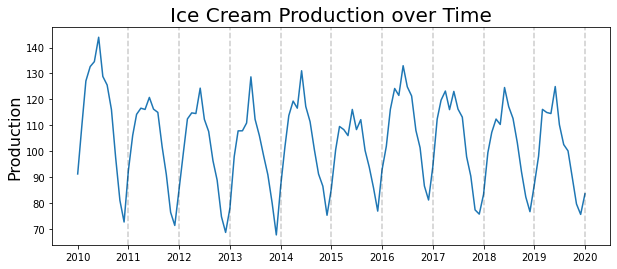

In [7]:
pylab.figure(figsize=(10,4))
pylab.plot(production_ice_cream)
pylab.title('Ice Cream Production over Time', fontsize=20)
pylab.ylabel('Production', fontsize=16)
for year in range(2011, 2021):
    pylab.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

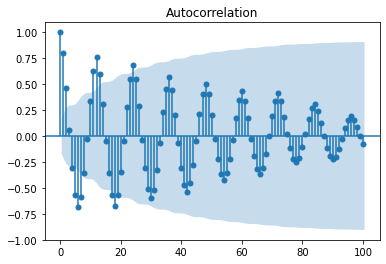

In [8]:
acf_plot = plot_acf(production_ice_cream, lags=100)

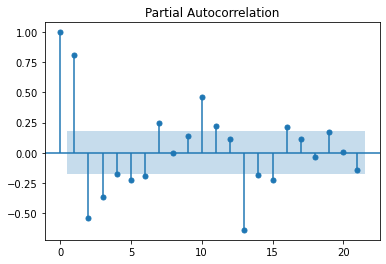

In [9]:
pacf_plot = plot_pacf(production_ice_cream)

In [10]:
train_end = datetime(2018, 12, 1)
test_end = datetime(2019, 12, 1)

train_data = production_ice_cream[:train_end]
test_data = production_ice_cream[train_end + timedelta(days=1):test_end]

In [11]:
# define model
model = ARIMA(train_data, order=(3, 0, 0))

In [12]:
#fit the model
model_fit = model.fit()

In [13]:
#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              IPN31152N   No. Observations:                  108
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -374.085
Date:                Mon, 15 Feb 2021   AIC                            758.170
Time:                        19:45:12   BIC                            771.580
Sample:                    01-01-2010   HQIC                           763.607
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.5743      2.169     47.761      0.000      99.324     107.825
ar.L1          1.0469      0.102     10.256      0.000       0.847       1.247
ar.L2         -0.0523      0.175     -0.298      0.7

The AR(3) model is:

$\hat{y_t} = 103.57 + 1.05y_{t - 1} - 0.05*y_{t - 2} -0.40*y_{t - 3}$

Note that the $y_{t -2}$ coefficient is not significantly different from 0, so we could drop it from our predictions

In [14]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [15]:
#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

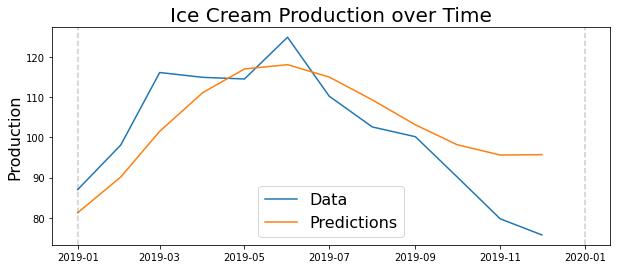

In [16]:
pylab.figure(figsize=(10,4))

pylab.plot(test_data)
pylab.plot(predictions)

pylab.legend(('Data', 'Predictions'), fontsize=16)

pylab.title('Ice Cream Production over Time', fontsize=20)
pylab.ylabel('Production', fontsize=16)
for year in range(2019,2021):
    pylab.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

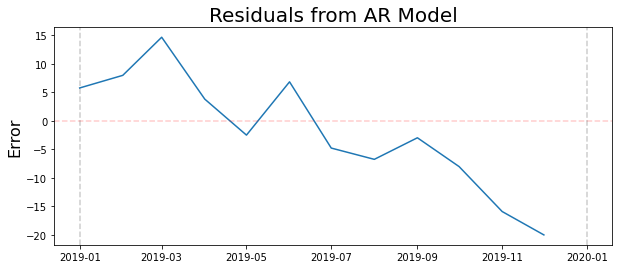

In [17]:
pylab.figure(figsize=(10, 4))
pylab.plot(residuals)
pylab.title('Residuals from AR Model', fontsize=20)
pylab.ylabel('Error', fontsize=16)
pylab.axhline(0, color='r', linestyle='--', alpha=0.2)
for year in range(2019,2021):
    pylab.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Error')

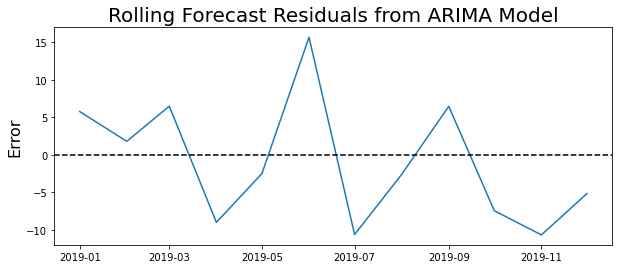

In [59]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = production_ice_cream[:train_end-timedelta(days=1)]
    model = ARIMA(train_data, order=(3,0,0))
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred
    
rolling_residuals = test_data - rolling_predictions
pylab.figure(figsize=(10,4))
pylab.plot(rolling_residuals)
pylab.axhline(0, linestyle='--', color='k')
pylab.title('Rolling Forecast Residuals from AR Model', fontsize=20)
pylab.ylabel('Error', fontsize=16)

In [60]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.0895


In [61]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 9.884158747519644


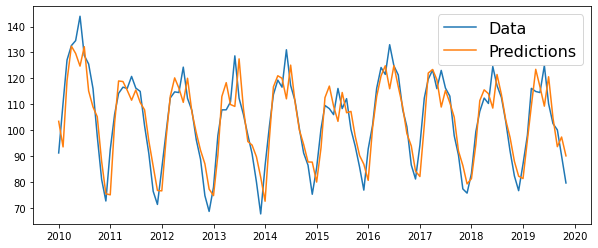

In [62]:
pylab.figure(figsize=(10,4))

pylab.plot(train_data)
pylab.plot(model_fit.predict(start=train_data.index[0], end=train_data.index[-1]))

pylab.legend(('Data', 'Predictions'), fontsize=16)